In [4]:
import networkx as nx

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models import Word2Vec
import itertools
import math
import random
from joblib import Parallel, delayed

In [20]:
#随机游走
class RandomWalker:
    def __init__(self, G, p=1, q=1):
        """
        G:图
        p:Return parameter,controls the likelihood of immediately revisiting a node in the walk，方便后续扩展其他graph embedding算法
        q:In-out parameter,allows the search to differentiate between “inward” and “outward” nodes，方便后续扩展其他graph embedding算法
        """
        self.G = G
        self.p = p
        self.q = q
    #随机游走是可以重复访问已遍历节点的深度优先遍历算法
    def deepwalk_walk(self, walk_length, start_node):
        """
        walk_length:对于每个节点，每次游走的长度
        start_node：开始的节点
        """
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(self.G.neighbors(cur))
            if len(cur_nbrs) > 0:
                walk.append(random.choice(cur_nbrs))
            else:
                break
        return walk
    def simulate_walks(self, num_walks, walk_length, workers=1, verbose=0):
        """
        num_walks:所有节点随机游走的次数
        walk_length:每次随机游走的长度
        wokers,verbose:用于多线程处理中
        """
        G = self.G
        nodes = list(G.nodes())
        walks = self._simulate_walks(nodes, num_walks, walk_length)
        #多线程同时处理
#         result = Parallel(n_jobs=workers, verbose=verbose,)(delayed(self._simulate_walks)(nodes, num, walk_length) for num in 
#                                                            partition_num(num_walks, workers))
#         walks = list(itertools.chain(*results))
        return walks
    def _simulate_walks(self, nodes, num_walks, walk_length,):
        """
        nodes:所有结点
        num_walks:所有节点随机游走的次数
        walk_length:每次游走的长度
        """
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                if self.p == 1 and self.q == 1:
                    walks.append(self.deepwalk_walk(walk_length=walk_length, start_node=v))
        return walks
def partition_num(num, workers):
    if num % workers == 0:
        return [num // workers] * workers
    else:
        return [num // workers] * workers + [num % workers]

In [24]:
#deepwalk算法:随机游走生成序列+word2vec(skip-gram+hierarchical softmax),最终生成每个节点的向量表示
class DeepWalk:
    def __init__(self, graph, walk_length, num_walks, workers=1):
        """
        graph:构建的图
        walk_length:每次随机游走的长度
        num_walks:全部节点随机游走的次数
        """
        self.graph = graph
        self.w2v_model = None
        self._embeddings = {}
        self.walker = RandomWalker(graph, p=1, q=1,)
        self.sentences = self.walker.simulate_walks(num_walks=num_walks, walk_length=walk_length, workers=workers, verbose=1)
#         print(self.sentences)
    def train(self, embed_size=128, window_size=5, workers=3, iter=5, **kwargs):
        kwargs['sentences'] = self.sentences
        kwargs['min_count'] = kwargs.get('min_count', 0)
        kwargs['size'] = embed_size
        kwargs['sg'] = 1 #skip gram
        kwargs['hs'] = 1 #deepwalk use Hierarchical softmax
        kwargs['workers'] = workers
        kwargs['window'] = window_size
        kwargs['iter'] = iter
        
        print('Learning embedding vectors...')
        model = Word2Vec(**kwargs)
        print('Learning embedding vectors done!')
        
        self.w2v_model = model
        return model
    def get_embeddings(self,):
        if self.w2v_model is None:
            print('model not train')
            return {}
        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.w2v_model.wv[word]
        return self._embeddings

In [29]:
print(embeddings['1249'])

[ 0.14158936 -0.19026662 -0.00088666 -0.02102085 -0.03617052 -0.22639135
 -0.02177147 -0.0538372   0.19911034  0.04255069 -0.11841511  0.0761356
 -0.14528713  0.02886692  0.04774599  0.02478966  0.11901003 -0.10386422
  0.1369398   0.24596521 -0.04369562 -0.08814903  0.16629766  0.21871282
  0.11733501  0.11408569  0.09503113  0.02661797  0.04840347  0.06202842
  0.12200096 -0.09114467  0.16252743 -0.09935571  0.10927366 -0.10851347
 -0.04694844 -0.00071432  0.1473464   0.08517222  0.21768185  0.01149646
 -0.15204638  0.0440795   0.00392157  0.04404078 -0.00761694 -0.04487455
 -0.08848774  0.02975646  0.21050589 -0.07754095 -0.21552038  0.05810364
 -0.212722   -0.07812112 -0.01057121 -0.00977048  0.0313421   0.1214268
  0.00457414  0.01087783 -0.26528284  0.14749019  0.02839963  0.11721546
 -0.01973013 -0.09952794 -0.04961507 -0.02607364  0.16222909  0.04943633
  0.05919591  0.03722446  0.02513321  0.03184892  0.06136868  0.02450917
 -0.14767511 -0.0627997  -0.10546181 -0.00553152 -0.0

In [44]:
#构建多分类的分类器，因为wiki的数据是多分类数据，使用基于deepwalk生成的每个节点的向量表示来训练模型预测标签结果
#deekwalk算法的应用，利用deepwalk算法进行wiki上的节点分类
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        probs = np.asarray(super(TopKRanker,self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)
class Classifier(object):
    def __init__(self, embeddings, clf):
        self.embeddings = embeddings
        self.clf = TopKRanker(clf)
        #对于多分类任务，便捷的生成多分类标签，比如标签为[1,2,3]，会生成[[1,0,0],[0,1,0],[0,0,1]]
        self.binarizer = MultiLabelBinarizer(sparse_output=True)
    def train(self, X, Y, Y_all):
        self.binarizer.fit(Y_all)
        #训练时用每个节点的deepwalk的向量表示数据
        X_train = [self.embeddings[x] for x in X]
        Y = self.binarizer.transform(Y)
        self.clf.fit(X_train, Y)
    def evaluate(self, X, Y):
        top_k_list = [len(l) for l in Y]
        Y_ = self.predict(X, top_k_list)
        Y = self.binarizer.transform(Y)
        #f1-score各种方式的计算结果
        averages = ['micro', 'macro', 'samples', 'weighted']
        results = {}
        for average in averages:
            results[average] = f1_score(Y, Y_, average=average)
        results['acc'] = accuracy_score(Y, Y_)
        print(results)
        return results
    def predict(self, X, top_k_list):
        #预测时 用每个节点的deepwalk向量表示数据
        X_ = np.asarray([self.embeddings[x] for x in X])
        Y = self.clf.predict(X_, top_k_list=top_k_list)
        return Y
    def split_train_evaluate(self, X, Y, train_percent, seed=0):
        state = np.random.get_state()
        training_size = int(train_percent * len(X))
        np.random.seed(seed)
        shuffle_indices = np.random.permutation(np.arange(len(X)))
        X_train = [X[shuffle_indices[i]] for i in range(training_size)]
        Y_train = [Y[shuffle_indices[i]] for i in range(training_size)]
        X_test = [X[shuffle_indices[i]] for i in range(training_size, len(X))]
        Y_test = [Y[shuffle_indices[i]] for i in range(training_size, len(X))]
        
        self.train(X_train, Y_train, Y)
        np.random.set_state(state)
        return self.evaluate(X_test,Y_test)
#读取数据函数
def read_node_label(filename, skip_head=False):
    fin = open(filename, 'r')
    X = []
    Y = []
    while 1:
        if skip_head:
            fin.readline()
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        X.append(vec[0])
        Y.append(vec[1:])
    fin.close()
    return X, Y

In [50]:
def evaluate_embeddings(embeddings):
    X, Y = read_node_label('./wiki/wiki_labels.txt')
    tr_frac = 0.8
    print('Training classifier using {:.2f}% nodes...'.format(tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)
def plot_embeddings(embeddings,):
    X, Y = read_node_label('./wiki/wiki_labels.txt')
    
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)
    
    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)
    
    plt.figure(figsize=(12,12))
    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)
    
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()

In [5]:
#构建图
G = nx.read_edgelist('./wiki/Wiki_edgelist.txt', create_using=nx.DiGraph(), nodetype=None, data=[('weight', int)])

In [28]:
model = DeepWalk(G, walk_length=10, num_walks=3, workers=1)
model.train(window_size=5, iter=3, min_count=2)
embeddings = model.get_embeddings()

Learning embedding vectors...
Learning embedding vectors done!


In [46]:
evaluate_embeddings(embeddings)

Training classifier using 80.00% nodes...
{'micro': 0.5135135135135135, 'macro': 0.4116794430734262, 'samples': 0.5135135135135135, 'weighted': 0.5085924198014948, 'acc': 0.5135135135135135}


/data1/guoyuhao/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


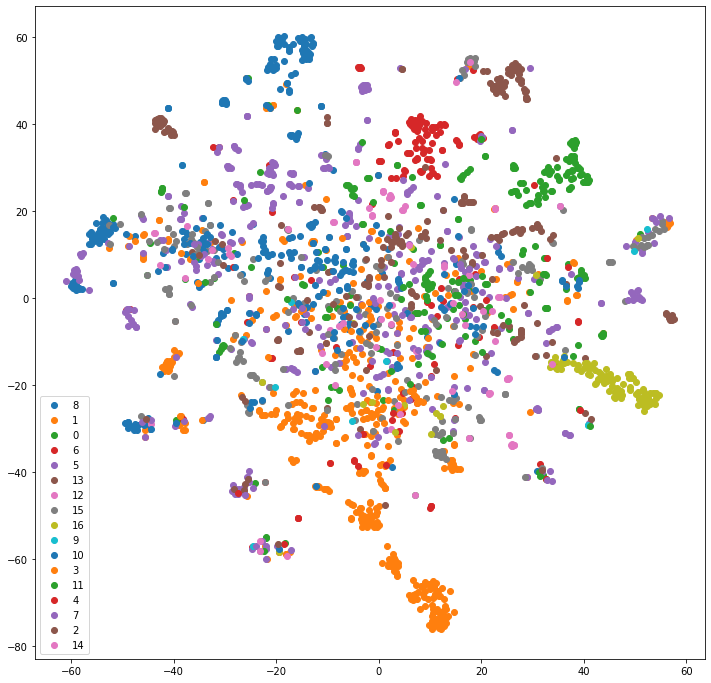

In [51]:
plot_embeddings(embeddings)